### Imports


In [1]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# helper tools
from scripts.get_sail_data import get_sail_data
from scripts.helper_funcs import create_windrose_df, simple_sounding, mean_sounding
import scripts.helper_funcs as hf
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# run nc deep_clean
import nctoolkit as nc
nc.deep_clean()

nctoolkit is using Climate Data Operators version 2.3.0


In [2]:
# Function to load ARM credentials
def load_arm_credentials(credential_path):
    with open(credential_path, 'r') as f:
        credentials = json.load(f)
    return credentials
# Location of ARM credentials
credential_path = '/home/dlhogan/.act_config.json'
credentials = load_arm_credentials(credential_path)
# api token and username for ARM
api_username = credentials.get('username')
api_token = credentials.get('token')

sail_datastream_dict = {
    "tropoe":"guctropoeM1.c1"
}

In [3]:
winter_22 = ('20211201','20220401')
winter_23 = ('20221201','20230401')

In [4]:
# Set the location of the data folder where this data will be stored
winter_22_folder = 'winter_21_22'
winter_23_folder = 'winter_22_23'
 # change to location of data folder on your machine
storage_directory = f'/storage/dlhogan/synoptic_sublimation/'
# create a sail_data folder if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data')):
    os.makedirs(os.path.join(storage_directory,'sail_data'))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_22_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_22_folder))
# create a folder for the event if it does not exist
if not os.path.exists(os.path.join(storage_directory,'sail_data',winter_23_folder)):
    os.makedirs(os.path.join(storage_directory,'sail_data',winter_23_folder))
    # make a radiosonde folder if it does not exist

In [5]:
# load in the winter 22 data
sail_winter_22_folder = os.path.join(storage_directory,'sail_data',winter_22_folder)
# create empty data dictionary
w22_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():

    if (os.path.exists(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')): 
        print(f'{k}_{winter_22[0]}_{winter_22[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_22[0],
                        enddate=winter_22[1])
        ds.to_netcdf(f'{sail_winter_22_folder}/{k}_{winter_22[0]}_{winter_22[1]}.nc')
        w22_data_loc_dict[k] = os.path.join(sail_winter_22_folder,f'{k}_{winter_22[0]}_{winter_22[1]}.nc')

tropoe_20211201_20220401.nc already exists
-------------------


In [6]:
# open the data
tropoe_w22 = xr.open_dataset(w22_data_loc_dict['tropoe'])

In [7]:
# load in the winter 23 data
sail_winter_23_folder = os.path.join(storage_directory,'sail_data',winter_23_folder)
# create empty data dictionary
w23_data_loc_dict = {}
# Iterate through the dictionary and pull the data for each datastream
for k,v in sail_datastream_dict.items():

    if (os.path.exists(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')): 
        print(f'{k}_{winter_23[0]}_{winter_23[1]}.nc already exists')
        print('-------------------')
        # add the filename to the dictionary which can be used if we want to load the data
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')
        continue
    else:
        # explicitly download radiosonde data because they are a lot easier to process and think about when in individual files
        ds = get_sail_data(api_username,
                        api_token,
                        v,
                        startdate=winter_23[0],
                        enddate=winter_23[1])
        ds.to_netcdf(f'{sail_winter_23_folder}/{k}_{winter_23[0]}_{winter_23[1]}.nc')
        w23_data_loc_dict[k] = os.path.join(sail_winter_23_folder,f'{k}_{winter_23[0]}_{winter_23[1]}.nc')

tropoe_20221201_20230401.nc already exists
-------------------


In [18]:
w23_tropoe_ds = xr.open_dataset(w23_data_loc_dict['tropoe'])
subset_ds = w23_tropoe_ds.sel(time=slice('2023-03-03','2023-03-09'), height=slice(0,3)).resample(time='1H').mean()

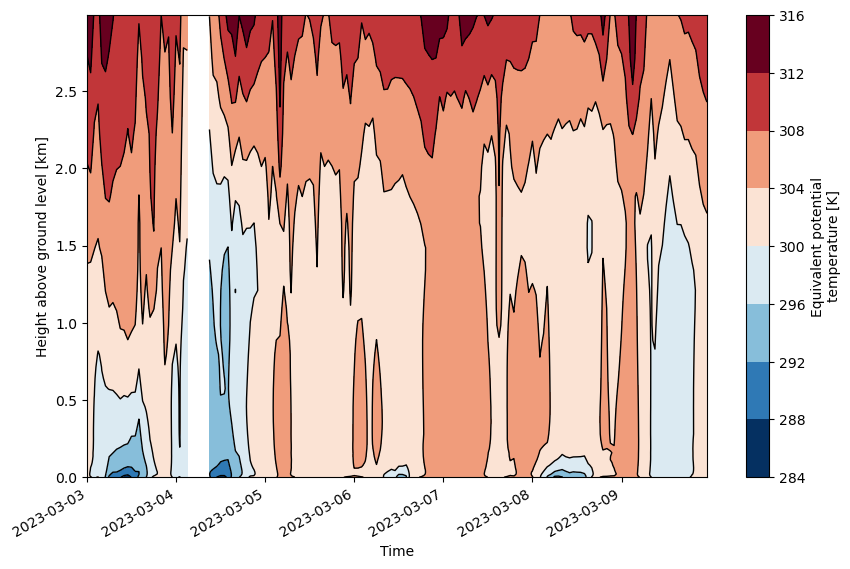

In [19]:

# set up a contour plot of the data using contour and contourf
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# plot the data
subset_ds['thetae'].plot.contourf(x='time',ax=ax, levels=10, cmap='RdBu_r')
subset_ds['thetae'].plot.contour(x='time',ax=ax, levels=10, colors='k', linewidths=1, linestyles='-')